# Particle Swarm Optimization
## Gerardo Durán Martín
### Queen Mary University of London | School of Mathematical Sciences

In [110]:
using Plots
using LaTeXStrings
using Random

In this exercise, we implement the Swarm Optimisation (PSO) algorithm for finding the minimum of a function $f: \mathbb{R}^M \to \mathbb{R}$.

> Particle swarm optimization (PSO) is a stochastic population-based optimization
method proposed by Kennedy and Eberhart (1995).

PSO is a variant of an unconstraint optimisation problem which is defined as the following problem

$$
    \text{find }{\bf x}^* \in S \subseteq \mathbb{R} \text{ such that }\forall {\bf x}\in S. f({\bf x}^*) \leq f({\bf x})
$$

Where
* $S$ is known as the *search space*
* The space $\{f(x) \vert x \in S\}$ is known as the *landscape* of the problem

## The  PSO

The  PSO algorithm implemented in this notebook considers a collection (swarm) of $N$ particles at time $t$ as a tuple $P_0 = \{({\bf x}_{n,t}, {\bf v}_{n,t}, {\bf p}_{n,t})\}_{n=1}^N$

where
* ${\bf x}_{n,t} \in \mathbb{R}^M$ is the **position** of the $n$-particle at time $t$
* ${\bf v}_{n,t}  \in \mathbb{R}^M$ is the **velocity** of the $n$-particle at time $t$. Is specifies the direction and lenght of the movement of the $n$-th particle
* ${\bf p}_{n,t}  \in \mathbb{R}^M$ is the **best position** of the $n$-particle at time $t$, i.e., $ \forall \tau \leq t . f({\bf p}_{n,t}) \leq f({\bf x}_{n,\tau})$

We also consider an aditional element
* ${\bf g}_t$ as the **best global vector** at iteration $t$., i.e., 

$$
    \forall \tau \leq t.\forall n\in\{1,\ldots, N\} f({\bf g}_{t}) \leq f({\bf x}_{n,\tau})$
$$

### Initialisiation
At time $t=0$, the swarm is initialised as follows:

* Define $b_\text{low}$, $b_\text{low}$, and $v_\text{init}$
* $\forall n.$ initialise ${\bf x}_{0,n}$ as an $M$-dimensional uniformly-distributed random vector between $b_\text{low}$ and $b_\text{low}$
* $\forall n.$ initialise ${\bf p}_{0,n} := {\bf x}_{0,n}$
* Define ${\bf g}_0 \in P_0$ such that $f({\bf g}_0) = \min_n f({\bf x}_{0, n})$


### Update Iteration
At time $t+1$, the $n$-th particle is updated as follows:

$$
\begin{align*}
    {\bf v}_{n,t+1} &= \omega {\bf v}_{n, t} + \varphi_p r_p({\bf p}_{n, t} - {\bf x}_{n, t}) + \varphi_g r_g ({\bf g}_{t} - {\bf x}_{n, t})\\
    {\bf x}_{n,t+1} &= {\bf x}_{n,t+1} + \alpha {\bf v}_{n,t+1}\\
    {\bf p}_{n,t+1} &= \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(p_{t, n})\\
        p_{t, n} & \text{otherwise}
    \end{cases}
\end{align*}
$$

Also

$$
    {\bf g}_{t+1} = \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(g_{t, n})\\
        g_{t} & \text{otherwise}
    \end{cases}
$$

Where

* $\omega$ is the *influence* of previous velocity
* $\varphi_p$ is the cognitive effect factor
* $\varphi_g$ is social influence factor
* $\alpha$ is the learning rate
* $r_p,\sim U[0, 1]$
* $r_g,\sim U[0, 1]$

### End of the algorithm
For our implementation, the algorithm finishes once we've exceeded a maximum number of iteration or whenever the biggest $L_2$-norm between changes of the positions is below some fixed value, i.e., we define the stopping time $\tau$ as the first time that $\max_n||p_{n, \tau - 1} - p_{n, \tau}|| < \varepsilon$ or $\tau=T$, whichever happens first.

In [15]:
f(x, y) = sin(x ^ 2 / 2 - y ^ 2 /  4 + 3) * cos(2x + 1 - exp(y))

f (generic function with 1 method)

In [17]:
xrange = -5:0.1:4
yrange = -5:0.1:3
Z = map(X -> f(X[2], X[1]), Base.product(yrange, xrange));

## Problem specification

In this notebook, we will be analising the following function

$$
    f(x,y) = \sin\left(\frac{1}{2}x^2 - \frac{1}{4}y^4 + 3 \right) \cos(2x + 1 - \exp(y))
$$

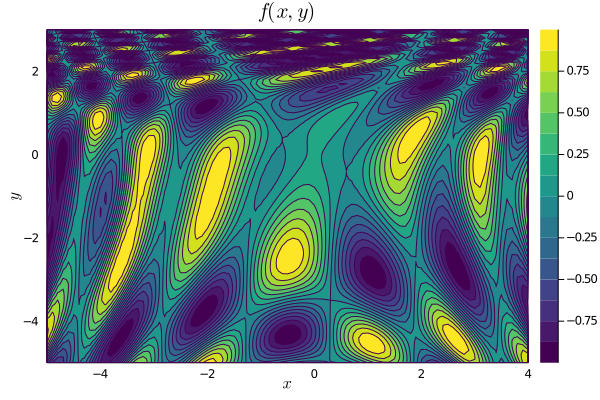

In [18]:
title = L"f(x,y)"
contourf(xrange, yrange, Z, c=:viridis, title=title, xlabel=L"x", ylabel=L"y")

In [19]:
"""
Struct that captures the characteristic of a PSO
Swarm at time t.
"""
mutable struct Swarm
    n_particles::Int32
    g::Array{Float64,1}
    positions::Array{Float64,2}
    best_positions::Array{Float64,2}
    velocities::Array{Float64,2}
    n_iterations::Int32
    n_dims::Int32
    
    function Swarm(b_low, b_up, d, n_particles, seed=nothing)
        if seed != nothing
            Random.seed!(seed)
        end
        g = [0., 0.]
        v_init = abs(b_up - b_low)
        positions = b_low .+ (b_up - b_low) * rand(Float64, (n_particles, d))
        velocity = -v_init .+ 2v_init * rand(Float64, (n_particles, d));
        
        new(n_particles, g, positions, copy(positions), velocity, 0, d)
    end
end

"""
Function to initialise a PSO swarm
"""
function initialize_g!(swarm::Swarm, f::Function)
    if swarm.n_iterations > 0
        @warn "Swarm already initialized"
        return f(swarm.g...)
    end
    
    for position in eachrow(swarm.best_positions)
        if f(position...) < f(swarm.g...)
            swarm.g = position
        end
    end
    f(swarm.g...)
end


function compute_new_velocity(swarm::Swarm, n::Int64, d::Int64,
                              ω::Float64, ϕp::Float64, ϕg::Float64,
                              seed=nothing)::Float64
    if seed != nothing
        Random.seed!(seed)
    end
    
    xd = swarm.positions[n, d]
    pd = swarm.best_positions[n, d]
    gd = swarm.g[d]
    velocity = swarm.velocities[n, d]
    rp = rand()
    rg = rand()
    
    new_velocity = ω * velocity + ϕp * rp * (pd - xd) + ϕg * rg * (gd - xd)
end


function update_position!(swarm::Swarm, f::Function, n::Int64, ω::Float64,
                          ϕp::Float64, ϕg::Float64, α::Float64)
    for d = 1:swarm.n_dims
        swarm.velocities[n, d] = compute_new_velocity(swarm, n, d, ω, ϕp, ϕg)
    end
    
    x_old = swarm.positions[n, :]
    p_old = swarm.best_positions[n, :]
    
    x_new = swarm.positions[n, :] .+ α * swarm.velocities[n, :]
    swarm.positions[n, :] = x_new
    
    p_new = p_old
    if f(x_new...) < f(p_old...)
        p_new = x_new
        swarm.best_positions[n, :] = p_new
        if f(x_new...) < f(swarm.g...)
            swarm.g = x_new
        end
    end
    
    l2 = sqrt(sum((p_old - p_new) .^ 2))
end


function update_swarm!(swarm::Swarm, f::Function, ω::Float64,
                          ϕp::Float64, ϕg::Float64, α::Float64)
    max_l2 = -Inf
    for n=1:swarm.n_particles
        l2 = update_position!(swarm, f, n, ω, ϕp, ϕg, α)
        max_l2 = l2 > max_l2 ? l2 : max_l2
    end
    max_l2
end


function fit!(swarm::Swarm, f::Function, ω::Float64, ϕp::Float64,
              ϕg::Float64, α::Float64, maxit=1_000, l2_break=1e-3;
              return_hist=false)
    initialize_g!(swarm, f)
    
    if return_hist
        # Position × velocity
        hist = zeros(2, maxit, swarm.n_particles, swarm.n_dims)
        hist[1, begin, :, :] = swarm.positions
        hist[2, begin, :, :] = swarm.velocities
    end
    
    nit = 2
    converge = false
    while !converge || nit == maxit
        max_l2 = update_swarm!(swarm, f, ω, ϕp, ϕg, α)
        
        if return_hist
            hist[1, nit, :, :] = swarm.positions
            hist[2, nit, :, :] = swarm.velocities
        end
        
        converge = max_l2 < l2_break ? true : false
        nit += 1
    end
    
    if return_hist
        return hist[:, begin:nit-1, :, :]
    end
end


"""
Funcition to plot the swarm and velocities at a given time

# Arguments
- `swarm_hist::Array{Float64, 4}`: Array of type (2, n_hist, n_swarm, 2)
    It is the result of computing fit!(swarm, return_hist=true)
- `plot_arrows::Bool`: Plot the velocities of the swarm
- `n::Int64`: Iteration of the history to plot
"""
function plot_swarm!(swarm_hist::Array{Float64, 4}, n::Int64, plot_arrows::Bool=true)
    positions = swarm_hist[1, n, :, :]
    velocities = swarm_hist[2, n, :, :]
    scatter!(eachcol(positions)..., label=nothing)
    
    if plot_arrows
        arrows = quiver_arrow(velocities[:, 1], velocities[:, 2])
         quiver!(positions[:, 1], positions[:, 2],
                 quiver=(2 .* arrows), color=:lightBlue, linewidth=1)
    end

end

plot_swarm!

In [20]:
Base.show(io::IO, m::MIME"text/plain", x::Swarm) = print(io,
    "Swarm(particles=$(x.n_particles), nits=$(x.n_iterations))")

function quiver_arrow(X, Y)
    Xdot = X ./ sqrt(sum(X .^ 2) + sum(Y .^ 2))
    Ydot = Y ./ sqrt(sum(X .^ 2) + sum(Y .^ 2))
    
    Xdot, Ydot
end

quiver_arrow (generic function with 1 method)

In [21]:
n_particles = 20
b_low, b_up = -4, 2
b_low, b_up = -5, 2.5
#ω, ϕp, ϕg, α = 0.4, 0.1, 0.1, 0.5
ω, ϕp, ϕg, α = 0.1, 0.4, 0.02, 0.5
ω, ϕp, ϕg, α = 0.01, 0.1, 0.05, 0.9

(0.01, 0.1, 0.05, 0.9)

## Analysis and Experiments

To see how the PSO algorithm works, we consider the PSO algorithm applied to the function defined above

In [128]:
n_particles = 20
b_low, b_up = -5, 2.5
ω, ϕp, ϕg, α = 0.01, 0.01, 0.05, 0.9

swarm = Swarm(b_low, b_up, 2, n_particles, 3141)
hist = fit!(swarm, f, ω, ϕp, ϕg, α, return_hist=true)
_, nits, _ = size(hist)

(2, 282, 20, 2)

In [129]:
plots = []
iterations = [1, 6, 20, 90]

for it in iterations
    p =  contourf(xrange, yrange, Z, c=:viridis, title="Iteration $it")
    plot_swarm!(hist, it)
    plot!(xlim=(-5, 4), ylim=(-5, 3))
    
    plots = vcat(plots, p)
end

plot(plots..., size=(800, 400))

Under this configuration, the particles start randomly around our defined $b_\text{low}$ and $b_\text{up}$ limits. After 6 iterations, the algortithn finds a minimum and all particles start tending towards ${\bf g}_6$. After 20 iterations, the swarm still hasn't found a better minimum, so it keeps tending towards ${\bf g}_6$. This procedure repeats

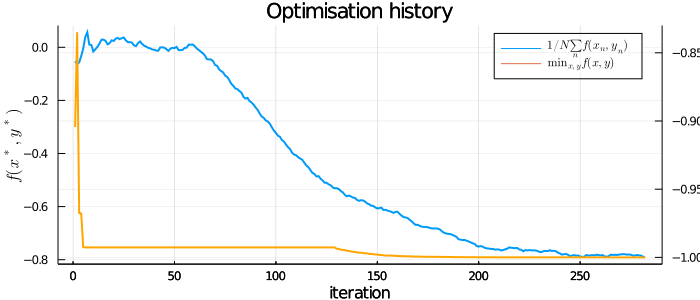

In [133]:
avg_hist = zeros(nits)
min_hist = zeros(nits)

for n=1:nits
    fxy = map(X -> f(X[1], X[2]), eachrow(hist[1, n, :, :]))
    x_bar = sum(fxy) / n_particles
    x_min = minimum(fxy)
    avg_hist[n] = x_bar
    min_hist[n] = x_min
end

plot(1:nits, avg_hist, label=L"1/N\sum_n f(x_n, y_n)", linewidth=2)
plot!(1:nits, (1:nits) .* NaN, label=L"\min_{x,y} f(x,y)")
plot!(twinx(), 1:nits, min_hist, label=nothing, c="orange", linewidth=2)
plot!(title="Optimisation history", size=(700, 300), xlabel="iteration", ylabel=L"f(x^*, y^*)")

## Hyperparameters

In [158]:
n_particles = 50
b_low, b_up = -5, 4
ω, ϕp, ϕg, α = 0.05, 0.5, 0.2, 0.1

swarm = Swarm(b_low, b_up, 2, n_particles, 3141)
hist = fit!(swarm, f, ω, ϕp, ϕg, α, 1000, return_hist=true)
_, nits, _ = size(hist)
print(nits)

145

In [159]:
f(swarm.g...)

-0.998745009677884

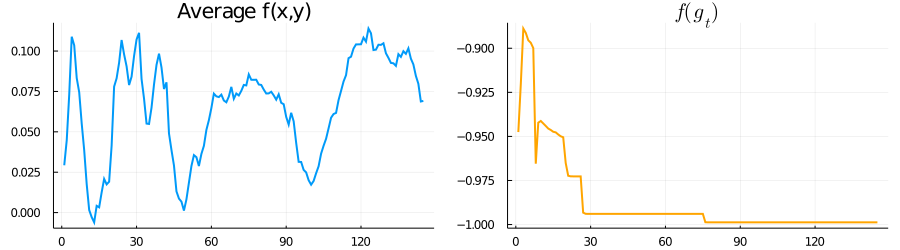

In [163]:
avg_hist = zeros(nits)
min_hist = zeros(nits)

for n=1:nits
    fxy = map(X -> f(X[1], X[2]), eachrow(hist[1, n, :, :]))
    x_bar = sum(fxy) / n_particles
    x_min = minimum(fxy)
    avg_hist[n] = x_bar
    min_hist[n] = x_min
end

p1 = plot(1:nits, avg_hist, title="Average f(x,y)", linewidth=2, label=nothing)
p2 = plot(1:nits, min_hist, title=L"f(g_t)", c="orange", linewidth=2, label=nothing)
plot(p1, p2, size=(900, 250))

In [161]:
f(swarm.g...)

-0.998745009677884

## A final graph

In [162]:
xrange = -5:0.1:4
yrange = -5:0.1:3
Z = map(X -> f(X[2], X[1]), Base.product(yrange, xrange))

f(x, y) = sin(x ^ 2 / 2 - y ^ 2 /  4 + 3) * cos(2x + 1 - exp(y))

f (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif
└ @ Plots /Users/gerardoduran/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/gerardoduran/Documents/repos/QMUL/MTH739U-topics-scientific-computing/exercises/tmp.gif")
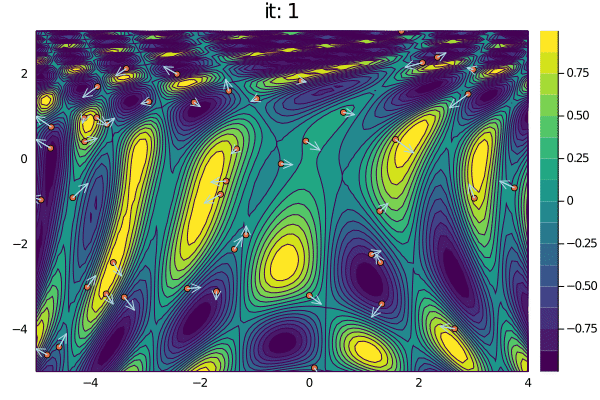

In [109]:
nframes = 100
nskip = Int(ceil(nits / nframes))

@gif for it=1:nits
    p =  contourf(xrange, yrange, Z, c=:viridis, title="it: $it")
    plot_swarm!(hist, it)
    plot!(xlim=(-5, 4), ylim=(-5, 3))
end every nskip